In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stocktrends import Renko
import statsmodels.api as sm
import yfinance as yf
import datetime as dt
import copy
import warnings
warnings.filterwarnings("ignore")

## Utility Functions


In [9]:
def ATR(DF,n):
    "function to calculate True Range and Average True Range"
    df = DF.copy()
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Adj Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Adj Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    #df['ATR'] = df['TR'].ewm(span=n,adjust=False,min_periods=n).mean()
    df2 = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return df2

def slope(ser,n):
    "function to calculate the slope of n consecutive points on a plot"
    slopes = [i*0 for i in range(n-1)]
    for i in range(n,len(ser)+1):
        y = ser[i-n:i]
        x = np.array(range(n))
        y_scaled = (y - y.min())/(y.max() - y.min())
        x_scaled = (x - x.min())/(x.max() - x.min())
        x_scaled = sm.add_constant(x_scaled)
        model = sm.OLS(y_scaled,x_scaled)
        results = model.fit()
        slopes.append(results.params[-1])
    slope_angle = (np.rad2deg(np.arctan(np.array(slopes))))
    return np.array(slope_angle)

def renko_DF(DF):
    "function to convert ohlc data into renko bricks"
    df = DF.copy()
    df.reset_index(inplace=True)
    df = df.iloc[:,[0,1,2,3,4,5]]
    df.columns = ["date","open","high","low","close","volume"]
    df2 = Renko(df)
    df2.brick_size = max(0.5,round(ATR(DF,120)["ATR"][-1],0))
    renko_df = df2.get_ohlc_data()
    renko_df["bar_num"] = np.where(renko_df["uptrend"]==True,1,np.where(renko_df["uptrend"]==False,-1,0))
    for i in range(1,len(renko_df["bar_num"])):
        if renko_df["bar_num"][i]>0 and renko_df["bar_num"][i-1]>0:
            renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
        elif renko_df["bar_num"][i]<0 and renko_df["bar_num"][i-1]<0:
            renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
    renko_df.drop_duplicates(subset="date",keep="last",inplace=True)
    return renko_df

def OBV(DF):
    """function to calculate On Balance Volume"""
    df = DF.copy()
    df['daily_ret'] = df['Adj Close'].pct_change()
    df['direction'] = np.where(df['daily_ret']>=0,1,-1)
    df['direction'][0] = 0
    df['vol_adj'] = df['Volume'] * df['direction']
    df['obv'] = df['vol_adj'].cumsum()
    return df['obv']

def CAGR(DF):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    n = len(df)/(252*78)
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return CAGR

def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    vol = df["ret"].std() * np.sqrt(252*78)
    return vol

def sharpe(DF,rf):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr
    

def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd

## Getting Stock data
We are mainly focusing on stocks which see a lot of day to day action, ie. mostly tech stocks which have high trading volumes daily.

In [21]:
tickers = ["MSFT", "AAPL", "META", "AMZN", "INTC", "CSCO", "VZ", "IBM", "TSLA", "AMD"]
ohlc_intraday = {}  # Dictionary to store OHLC data for each stock

# Define start and end dates for data retrieval
end_date = dt.datetime.today()
start_date = end_date - dt.timedelta(37)  # Fetch data for at least 36 days

# Loop over tickers and retrieve intraday OHLC data
for ticker in tickers:
    ohlc_intraday[ticker] = yf.download(ticker, start=start_date, end=end_date, interval='5m')
    ohlc_intraday[ticker].dropna(inplace=True, how="all")

# Adjust datetime index to UTC timezone for consistency
for ticker in tickers:
    ohlc_intraday[ticker].index = ohlc_intraday[ticker].index.tz_convert('UTC')

# Redefine tickers variable after removing any tickers with corrupted data
tickers = ohlc_intraday.keys() 

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## Processing
We merge the information from renko into our stock dataframe. Since we only need the bar close information we'll only integrate that column as all the other data columns are same. We will also initialise the ticker signal and ticker return dictionary which will be used later in generating signals and returns for each ticker.

In [43]:
df = copy.deepcopy(ohlc_intraday)
tickers_signal = {}
tickers_ret = {}
for ticker in tickers:
    renko = renko_DF(df[ticker])
    renko.set_index('date',inplace = True) # Converting the date from column to index to match df[ticker] 
    df[ticker]['bar_num'] = renko['bar_num']
    ohlc_renko = df
    ohlc_renko[ticker]["bar_num"].fillna(method='ffill',inplace=True)
    ohlc_renko[ticker]["obv"]= OBV(ohlc_renko[ticker])
    ohlc_renko[ticker]["obv_slope"]= slope(ohlc_renko[ticker]["obv"],5)
    tickers_signal[ticker] = ""
    tickers_ret[ticker] = []

## Backtesting
The algorithm will be monitoring all the stocks candle by candle and if our criterias are met at a particular candle, the algorithm will place a buy/sell order along with a pre set criteria to close the position.
#### Strategy Rules
BUY SIGNAL
1. Renko bar greater than or equal to 2.
2. 5 day OBV slope greater than 30 degrees.
3. Exit when renko bar is less than 2.

SELL SIGNAL
1. Renko bar less than or equal to -2.
2. 5 day OBV slope less than -30 degrees.
3. Exit when renko bar is greater than -2.

In [44]:
#Identifying signals and calculating  return
for ticker in tickers:
    for i in range(len(ohlc_intraday[ticker])):
        if tickers_signal[ticker] == "":
            tickers_ret[ticker].append(0)
            if ohlc_renko[ticker]["bar_num"][i]>=2 and ohlc_renko[ticker]["obv_slope"][i]>30: # Sending buy signal if buy conditions are met.
                tickers_signal[ticker] = "Buy"
            elif ohlc_renko[ticker]["bar_num"][i]<=-2 and ohlc_renko[ticker]["obv_slope"][i]<-30: # sending sell signal if sell conditions are met.
                tickers_signal[ticker] = "Sell"
        
        elif tickers_signal[ticker] == "Buy":
            tickers_ret[ticker].append((ohlc_renko[ticker]["Adj Close"][i]/ohlc_renko[ticker]["Adj Close"][i-1])-1)
            if ohlc_renko[ticker]["bar_num"][i]<=-2 and ohlc_renko[ticker]["obv_slope"][i]<-30: # reversing the trade if sell conditions are met.
                tickers_signal[ticker] = "Sell"
            elif ohlc_renko[ticker]["bar_num"][i]<2: # changing signal to no signal if exit conditions are met.
                tickers_signal[ticker] = ""
                
        elif tickers_signal[ticker] == "Sell":
            tickers_ret[ticker].append((ohlc_renko[ticker]["Adj Close"][i-1]/ohlc_renko[ticker]["Adj Close"][i])-1)
            if ohlc_renko[ticker]["bar_num"][i]>=2 and ohlc_renko[ticker]["obv_slope"][i]>30: # reversing the trade if buy conditions are met.
                tickers_signal[ticker] = "Buy"
            elif ohlc_renko[ticker]["bar_num"][i]>-2: # changing signal to no signal if exit conditions are met.
                tickers_signal[ticker] = ""
    ohlc_renko[ticker]["ret"] = np.array(tickers_ret[ticker])

## Calculating Overall Strategy's KPIs

In [53]:
strategy_df = pd.DataFrame()
for ticker in tickers:
    strategy_df[ticker] = ohlc_renko[ticker]["ret"]
strategy_df["ret"] = strategy_df.mean(axis=1)

In [54]:
print("CAGR for the startegy was ",CAGR(strategy_df))
print("Sharpe Ratio for strategy was ",sharpe(strategy_df,0.025))
print("Max Drawdown for strategy was ",max_dd(strategy_df)) 

CAGR for the startegy was  0.01004542999446767
Sharpe Ratio for strategy was  -0.10594846168865486
Max Drawdown for strategy was  0.03968767966490683


The KPIs show that this strategy is not that impressive at all. We have a negative sharpe ratio which is the first red flag. Also we have taken 3.9% drawdown for a CAGR of 0.1% which is not good risk to reward wise which is why the sharpe ratio is negative. 3.9% is a massive amount of drawdown to take considering we are just working on 1 month of backtest.

## Visualisation and Results

<function matplotlib.pyplot.show(close=None, block=None)>

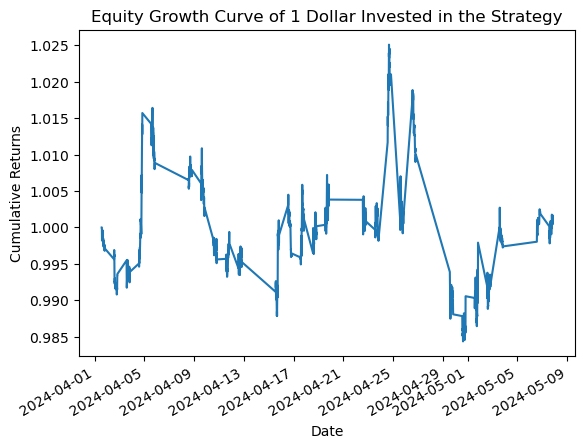

In [57]:
(1+strategy_df["ret"]).cumprod().plot()
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.title('Equity Growth Curve of 1 Dollar Invested in the Strategy')
plt.show

We can see a lot of volatility in this strategy and the returns are very erratic. The strategy has potential to generate good returns but also manages to lose the profits quickly. Seems like we have to work on the exit strategy a bit more and refine it.

## Calculating individual stock's KPIs

In [59]:
cagr = {}
sharpe_ratios = {}
max_drawdown = {}
for ticker in tickers:    
    cagr[ticker] =  CAGR(ohlc_renko[ticker])
    sharpe_ratios[ticker] =  sharpe(ohlc_renko[ticker],0.025)
    max_drawdown[ticker] =  max_dd(ohlc_renko[ticker])

KPI_df = pd.DataFrame([cagr,sharpe_ratios,max_drawdown],index=["Return","Sharpe Ratio","Max Drawdown"])      
KPI_df.T

,Return,Sharpe Ratio,Max Drawdown
MSFT,0.146972,0.675204,0.056486
AAPL,0.359998,1.189757,0.063095
META,-0.573444,-1.075842,0.203177
AMZN,0.877456,3.057205,0.059578
INTC,8.169896,16.624328,0.070526
CSCO,-0.132086,-1.132140,0.056793
VZ,-0.439180,-2.468541,0.100438
IBM,-0.878351,-2.923907,0.240188
TSLA,0.033311,0.012334,0.167692
AMD,-0.197577,-0.553020,0.156461


We can see that the returns are very extreme, ie the positive returns are very good but the negative returns are just as worse. META and IBM gave very bad returns because there was a news event involved with them and they opened with a massive gap down on April 25.